이 자료는 위키독스 딥 러닝을 이용한 자연어 처리 입문의 스팸 메일 분류하기 튜토리얼 자료입니다.  

링크 : https://wikidocs.net/22894  

이 자료는 2021년 10월 19일에 마지막으로 테스트되었습니다.

## **10-02 스팸 메일 분류하기(Spam Detection)**
---

캐글에서 제공하는 스팸 메일 데이터를 학습시켜 스팸 메일 분류기를 구현해보겠습니다.

In [2]:
import tensorflow as tf   # 2025.05 tf 2.19.0
tf.__version__

'2.19.0'

### **1. 스팸 메일 데이터에 대한 이해**

* 다운로드 링크 : https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

다운로드 받은 spam.csv 파일을 데이터프레임으로 로드하고 총 샘플의 수를 확인해봅시다.

In [4]:
# urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")
data = pd.read_csv('dataset/spam.csv', encoding='latin1')

총 5,572개의 샘플이 존재합니다. 상위 5개의 샘플만 출력해봅시다.

In [5]:
print('총 샘플의 수 :', len(data))

총 샘플의 수 : 5572


In [6]:
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


스팸 메일 데이터 중에서 5개의 행만 출력해보았습니다. 이 데이터에는 총 5개의 열이 있는데, 여기서 Unnamed라는 이름의 3개의 열은 텍스트 분류를 할 때 불필요한 열입니다. v1열은 해당 메일이 스팸인지 아닌지를 나타내는 레이블에 해당되는 열입니다. ham은 정상 메일을 의미하고, spam은 스팸 메일을 의미합니다. v2열은 메일의 본문을 담고있습니다.

레이블과 메일 내용이 담긴 v1열과 v2열만 필요하므로, Unnamed: 2, Unnamed: 3, Unnamed: 4 열은 삭제합니다. 또한, v1열에 있는 ham과 spam 레이블을 각각 숫자 0과 1로 바꾸겠습니다. 다시 data에서 5개의 행만 출력해보겠습니다.

In [7]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']
data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])
data

C:\Users\dlwlg\AppData\Local\Temp\ipykernel_7372\3655143902.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])


,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


불필요한 열이 제거되고 v1열의 값이 숫자로 변환된 것을 확인할 수 있습니다. 해당 데이터프레임의 정보를 확인해보겠습니다.

In [8]:
data.info()  # Null Check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


v1열은 정수형, v2열은 문자열 데이터를 갖고있습니다. Null 값을 가진 샘플이 있는지 isnull().values.any()로 확인합니다.

In [9]:
print('결측값 여부 :', data.isnull().values.any())

결측값 여부 : False


False는 별도의 Null 값은 없음을 의미합니다. 초기 데이터에 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'열에는 NaN이 있었는데 해당 상태에서 수행하는 isnull().values.any()는 True를 리턴합니다. Null 값이 없다면 데이터에 중복이 있는지 확인해보겠습니다.

In [10]:
print('v2열의 유니크한 값 :', data['v2'].nunique())

v2열의 유니크한 값 : 5169


총 5,572개의 샘플이 존재하는데 v2열에서 중복을 제거한 샘플의 개수가 5,169개라는 것은 403개의 중복 샘플이 존재한다는 의미입니다. 중복 샘플을 제거하고 전체 샘플 수를 확인합니다.

In [11]:
# v2 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['v2'], inplace=True)

In [12]:
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5169


총 샘플의 수가 5,572개에서 5,169개로 줄었습니다. 레이블 값의 분포를 시각화합니다.

### **탐색적 데이터 분석 : Exploratory Data Analysis (EDA)**

<Axes: xlabel='v1'>

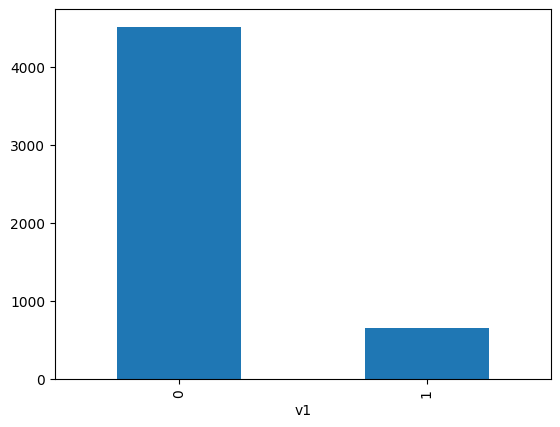

In [13]:
data['v1'].value_counts().plot(kind='bar')

레이블이 대부분 0에 편중되어있는데, 이는 스팸 메일 데이터의 대부분의 메일이 정상 메일임을 의미합니다. 정확한 수치를 파악해보겠습니다.

In [14]:
print('정상 메일과 스팸 메일의 개수')
print(data.groupby('v1').size().reset_index(name='count'))

정상 메일과 스팸 메일의 개수
   v1  count
0   0   4516
1   1    653


In [15]:
print(f'정상 메일의 비율 = {round(data["v1"].value_counts()[0] / len(data) * 100,3)}%')
print(f'스팸 메일의 비율 = {round(data["v1"].value_counts()[1] / len(data) * 100,3)}%')

정상 메일의 비율 = 87.367%
스팸 메일의 비율 = 12.633%


v2열과 v1열을 X데이터와 y데이터라는 X_data, y_data로 저장합니다.

In [16]:
X_data = data['v2']
y_data = data['v1']
print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [17]:
X_data[:3], y_data[:3]

(0    Go until jurong point, crazy.. Available only ...
 1                        Ok lar... Joking wif u oni...
 2    Free entry in 2 a wkly comp to win FA Cup fina...
 Name: v2, dtype: object,
 0    0
 1    0
 2    1
 Name: v1, dtype: int64)

훈련 데이터와 테스트 데이터를 분리합니다. 주의할 점은 현재 레이블이 굉장히 불균형합니다. 다시 말해 정상 메일 샘플(87%, 4516개)에 비해서 스팸 메일 샘플(12%, 653개)이 굉장히 적습니다. 만약, 훈련 데이터와 테스트 데이터를 분리하는 과정에서 우연히 대부분의 스팸 메일 샘플이 테스트 데이터에 포함되고 훈련 데이터에는 대부분 정상 메일 샘플만 포함되게 된다면 어떻게 될까요? 학습 과정에서 모델은 스팸 메일 샘플을 거의 관측하지 못해서 모델의 성능이 저하될 것입니다.

이렇게 레이블이 불균형한 경우에는 데이터를 나눌 때에도 훈련 데이터와 테스트 데이터에 각 레이블의 분포가 고르게 분포되도록 하는 것이 중요할 수 있습니다. 사이킷 런의 train_test_split에 stratify의 인자로서 레이블 데이터를 기재하면 훈련 데이터와 테스트 데이터를 분리할 때 레이블의 분포가 고르게 분포하도록 합니다. test_size에 0.2를 기재하여 훈련 데이터와 테스트 데이터를 8:2 비율로 분리합니다.

현재 레이블이 굉장히 불균형하기 때문에 분리 후에도

훈련 데이터와 테스트 데이터의 레이블 비율이 유지되도록 해줍시다.

이는 인자로서 stratify=y데이터를 사용하여 가능합니다.

In [18]:
# X_data와 y_data를 8:2 비율로 분할
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, 
                                                    random_state=0, stratify=y_data)

훈련 데이터와 테스트 데이터가 분리되었습니다. 레이블이 고르게 분포되었는지 확인합니다.

In [19]:
print('--------훈련 데이터의 비율-----------')
print(f'정상 메일 = {round(y_train.value_counts()[0] / len(y_train) * 100, 3)}%')
print(f'스팸 메일 = {round(y_train.value_counts()[1] / len(y_train) * 100, 3)}%')

--------훈련 데이터의 비율-----------
정상 메일 = 87.376%
스팸 메일 = 12.624%


In [20]:
print('--------테스트 데이터의 비율-----------')
print(f'정상 메일 = {round(y_test.value_counts()[0] / len(y_test) * 100, 3)}%')
print(f'스팸 메일 = {round(y_test.value_counts()[1] / len(y_test) * 100, 3)}%')

--------테스트 데이터의 비율-----------
정상 메일 = 87.331%
스팸 메일 = 12.669%


훈련 데이터와 테스트 데이터 모두 정상 메일은 87%, 스팸 메일은 12%가 존재합니다. 케라스 토크나이저를 통해 훈련 데이터에 대해서 **토큰화** 와 **정수 인코딩** 과정을 수행합니다. X_train_encoded에는 X_train의 각 단어들이 맵핑되는 정수로 인코딩되어 저장됩니다. 5개의 메일만 출력해서 확인해보겠습니다.

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)   # 토큰화
X_train_encoded = tokenizer.texts_to_sequences(X_train)  # 정수 인코딩

In [22]:
print(X_train_encoded[:5])

[[102, 1, 210, 230, 3, 17, 39], [1, 59, 8, 427, 17, 5, 137, 2, 2326], [157, 180, 12, 13, 98, 93, 47, 9, 40, 3485, 247, 8, 7, 87, 6, 80, 1312, 5, 3486, 7, 2327, 11, 660, 306, 20, 25, 467, 708, 1028, 203, 129, 193, 800, 2328, 23, 1, 144, 71, 2, 111, 78, 43, 2, 130, 11, 800, 186, 122, 1512], [1, 1154, 13, 104, 292], [222, 622, 857, 540, 623, 22, 23, 83, 10, 47, 6, 257, 32, 6, 26, 64, 936, 407]]


각 메일이 정수 인코딩이 되었습니다. 각 정수가 어떤 단어에 부여되었는지 확인해봅시다.

In [23]:
word_to_index = tokenizer.word_index  # 단어 사전
print(word_to_index)

{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'on': 17, 'call': 18, 'that': 19, 'are': 20, '2': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'can': 26, 'or': 27, "i'm": 28, 'get': 29, 'at': 30, 'do': 31, 'if': 32, 'be': 33, 'will': 34, 'just': 35, 'with': 36, 'we': 37, 'no': 38, 'this': 39, 'ur': 40, 'up': 41, '4': 42, 'how': 43, 'gt': 44, 'lt': 45, 'go': 46, 'when': 47, 'from': 48, 'what': 49, 'ok': 50, 'out': 51, 'know': 52, 'free': 53, 'all': 54, 'like': 55, 'then': 56, 'got': 57, 'good': 58, 'am': 59, 'time': 60, 'was': 61, 'come': 62, 'its': 63, 'love': 64, 'want': 65, 'text': 66, 'he': 67, 'only': 68, 'there': 69, 'day': 70, 'need': 71, 'going': 72, 'lor': 73, 'send': 74, 'one': 75, 'as': 76, 'home': 77, 'about': 78, 'back': 79, 'still': 80, 'k': 81, 'see': 82, 'txt': 83, 'by': 84, 'da': 85, 'stop': 86, 'r': 87, 'any': 88, 'tell': 89, 'dont': 90, "i'll": 91, "don't": 9

In [24]:
len(tokenizer.index_word)  # 총 단어수

7821

무수히 많은 단어가 출력되므로 출력 결과는 중간에 생략했습니다. 위에서 부여된 각 정수는 각 단어의 빈도수가 높을 수록 낮은 정수가 부여됩니다. 다시 말해, 단어 i는 현재 전체 훈련 데이터에서 빈도수가 가장 높은 단어입니다.

각 단어에 대한 **등장 빈도수** 는 `tokenizer.word_counts.items()`를 출력해서 확인할 수 있습니다. 이를 응용하여 빈도수가 낮은 단어들이 훈련 데이터에서 얼만큼의 비중을 차지하는지 확인해볼 수 있습니다. 등장 빈도수가 1회 밖에 되지 않는 단어들이 전체 단어 집합에서 얼만큼의 비율을 차지하며, 전체 훈련 데이터에서 등장 빈도로 얼만큼의 비율을 차지하는지 확인해보겠습니다.

In [25]:
threshold = 2
total_cnt = len(word_to_index)  # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율: %.2f %%" % ((rare_cnt / total_cnt) * 100) )
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율: %.2f %%" % ((rare_freq / total_freq) * 100) )

등장 빈도가 1번 이하인 희귀 단어의 수: 4337
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.45 %
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.66 %


등장 빈도가 threshold 값인 2회 미만. 즉, 1회 밖에 되지 않는 단어들은 단어 집합에서 무려 절반 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 6%밖에 되지 않습니다. 만약, 이러한 분석을 통해 **등장 빈도가 지나치게 낮은 단어들은 자연어 처리에서 제외** 하고 싶다면 케라스 토크나이저 선언 시에 **단어 집합의 크기를 제한할 수** 있습니다. 가령, 아래의 코드로 등장 빈도가 1회인 단어들을 제외할 수 있을 겁니다.

```python
    tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)  
```

하지만 이번 실습에서는 별도로 단어 집합의 크기를 제한하진 않겠습니다. 단어 집합의 크기를 vocab_size에 저장하겠습니다. 패딩을 위한 토큰인 0번 단어를 고려하며 +1을 해서 저장합니다.

In [26]:
vocab_size = len(word_to_index) + 1  # 0번 패딩을 위해 +1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 7822


단어 집합의 크기는 7,822입니다. 전체 데이터에서 가장 길이가 긴 메일과 전체 메일 데이터의 길이 분포를 확인합니다.

In [27]:
# X_train_encoded

In [28]:
X_data

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5169, dtype: object

In [29]:
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

메일의 최대 길이 : 189
메일의 평균 길이 : 15.754534


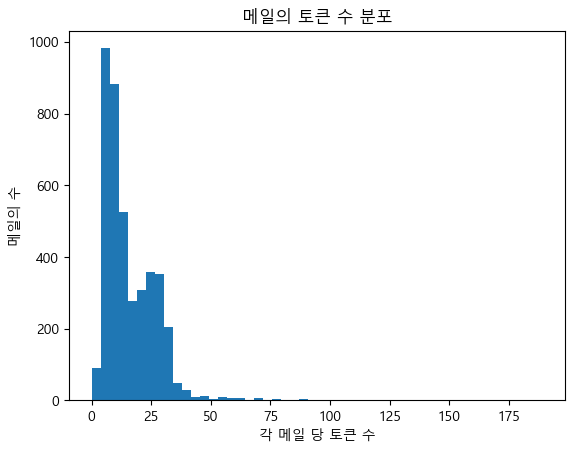

In [30]:
print('메일의 최대 길이 : %d' % max(len(l) for l in X_train_encoded)) # 훈련 데이터에서 가장 긴 메일의 토큰수
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded)) / len(X_train_encoded)))

## 각 메일의 토큰 수를 히스토그램으로 시각화
plt.hist([len(l) for l in X_train_encoded], bins=50)
plt.title('메일의 토큰 수 분포')
plt.xlabel('각 메일 당 토큰 수')
plt.ylabel('메일의 수')
plt.show()

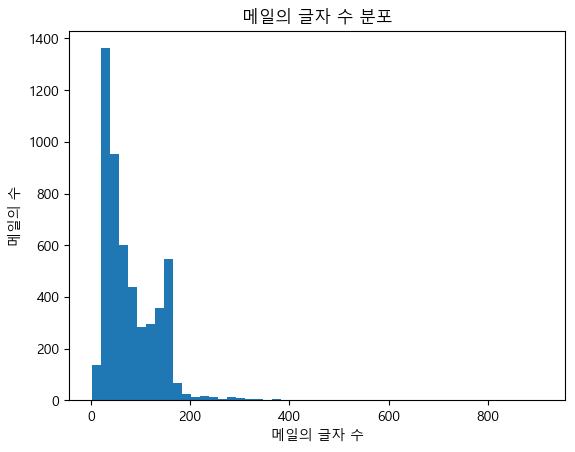

In [31]:
### 각 메일의 글자 수를 히스토그램으로 시각화
plt.hist([len(s) for s in X_data], bins=50)
plt.title('메일의 글자 수 분포')
plt.xlabel('메일의 글자 수')
plt.ylabel('메일의 수')
plt.show()

가장 긴 메일의 길이는 189이며, 전체 데이터의 길이 분포는 대체적으로 약 50이하의 길이를 가집니다.

In [32]:
max_len = 189
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
print("훈련 데이터의 크기(shape): ", X_train_padded.shape)

훈련 데이터의 크기(shape):  (4135, 189)


In [33]:
X_train_padded.shape, X_train_padded[:2]

((4135, 189),
 array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           

In [34]:
y_train

1882    0
4948    0
4460    0
4851    0
201     0
       ..
1971    0
3701    0
2809    0
1229    0
2531    0
Name: v1, Length: 4135, dtype: int64

maxlen에는 가장 긴 메일의 길이였던 189이라는 숫자를 넣었습니다. 이는 4,135개의 X_train_encoded의 길이를 전부 189로 바꿉니다. 189보다 길이가 짧은 메일 샘플은 전부 숫자 0이 패딩되어 189의 길이를 가집니다.

X_train_encoded 데이터는 4,135 × 189의 크기를 갖게됩니다. 모델을 설계해보겠습니다.

---
### **2. RNN으로 스팸 메일 분류하기**

하이퍼파라미터인 **임베딩 벡터의 차원** 은 32, **은닉 상태의 크기** 는 32입니다. 모델은 **다 대 일 구조의 RNN** 을 사용합니다. 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 **이진 분류** 문제를 수행하는 모델입니다. 이진 분류 문제의 경우, 출력층에 **로지스틱 회귀** 를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용하고, **손실 함수** 로 크로스 엔트로피 함수를 사용하여 4번의 에포크를 수행합니다.

하이퍼파라미터인 **배치 크기** 는 64이며, `validation_split=0.2`을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [35]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

In [36]:
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - acc: 0.8438 - loss: 0.4577 - val_acc: 0.9250 - val_loss: 0.2078
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - acc: 0.9537 - loss: 0.1631 - val_acc: 0.9674 - val_loss: 0.1090
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - acc: 0.9803 - loss: 0.0729 - val_acc: 0.9758 - val_loss: 0.0822
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.9894 - loss: 0.0374 - val_acc: 0.9794 - val_loss: 0.0712
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - acc: 0.9935 - loss: 0.0277 - val_acc: 0.9807 - val_loss: 0.0757
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.9958 - loss: 0.0155 - val_acc: 0.9843 - val_loss: 0.0722
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.9974 - loss: 0.0125 - val_acc: 0.9831 - val_loss: 0.0742
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - acc: 0.9899 - loss: 0.0356 - val_acc: 0.9819 - val_loss: 0.0773
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - acc: 0.9980

<Axes: >

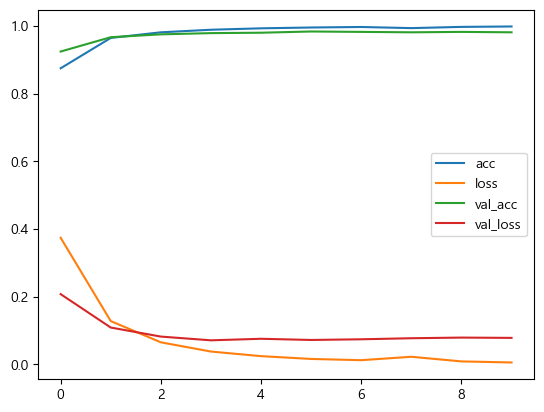

In [37]:
import pandas as pd
pd.DataFrame(history.history).plot()

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 189, 32)        │       250,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,836 (1.93 MB)

 Trainable params: 252,417 (986.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 252,419 (986.02 KB)

테스트 데이터에 대해서 정확도를 확인해보겠습니다.

In [41]:
## 반드시 학습 데이터에 사용한 tokenizer로 Test Data도 tokenize 해야 함!
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)

In [42]:
max_len, X_test_padded.shape

(189, (1034, 189))

In [43]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9856 - loss: 0.0676

 테스트 정확도: 0.9816


정확도가 98%가 나왔습니다. 이번 실습에서는 훈련 데이터와 검증 데이터에 대해서 같이 정확도를 확인하면서 훈련하였으므로, 이를 비교하여 그래프로 시각화해보겠습니다.

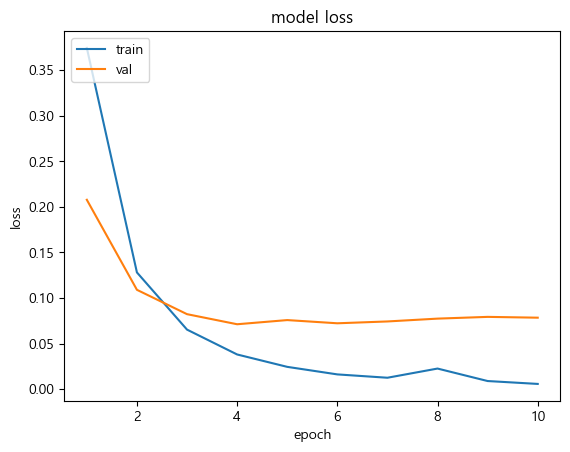

In [44]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

이번 실습 데이터는 데이터의 양이 적어 과적합이 빠르게 시작되므로, 검증 데이터에 대한 오차가 증가하기 시작하는 시점의 바로 직전인 에포크 3~4 정도가 적당합니다. 이 데이터는 에포크 5를 넘어가기 시작하면 검증 데이터의 오차가 증가하는 경향이 있습니다.

마지막 편집일시 : 2022년 11월 14일 3:08 오후

In [50]:
((model.predict(X_test_padded[:20]) > 0.5) * 1).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [46]:
X_test[2], y_test[2]

("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 1)

In [47]:
y_test

4183    0
108     0
5237    1
1858    0
3603    0
       ..
2086    0
5548    0
2254    0
3593    1
1174    0
Name: v1, Length: 1034, dtype: int64

In [ ]:
## 앞의 10개 이메일 정답 여부 체크
((model.predict(X_test_padded[:10]) > 0.5) * 1).flatten() == y_test[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


4183    True
108     True
5237    True
1858    True
3603    True
368     True
2       True
2444    True
2365    True
3791    True
Name: v1, dtype: bool

In [52]:
model.predict(X_test_padded[:10]).shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


(10, 1)

In [53]:
y_test[:10]

4183    0
108     0
5237    1
1858    0
3603    0
368     0
2       1
2444    0
2365    0
3791    0
Name: v1, dtype: int64

In [54]:
(model.predict(X_test_padded[:10]).flatten() > 0.5) * 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [55]:
X_test[:10]

4183    I just really need shit before tomorrow and I ...
108     I know! Grumpy old people. My mom was like you...
5237    Someonone you know is trying to contact you vi...
1858                     Sir, i am waiting for your call.
3603            Hey morning what you come to ask:-) pa...
368                            Wat uniform? In where get?
2       Free entry in 2 a wkly comp to win FA Cup fina...
2444       Yes but i dont care! I need you bad, princess!
2365          Ok try to do week end course in coimbatore.
3791    Love it! I want to flood that pretty pussy wit...
Name: v2, dtype: object

In [56]:
X_test.values[2]

'Someonone you know is trying to contact you via our dating service! To find out who it could be call from your mobile or landline 09064015307 BOX334SK38ch '

In [57]:
X_test.values[6]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"